### Read the input files to do some descriptive analysis and visualization

In [1]:
import sys
sys.path.append('eval/')
sys.path.append('models/')
sys.path.append('process_data/')

import datetime 
import geopandas as gpd
# import geoplot as gplt
# import geoplot.crs as gcrs
# import mapclassify as mc
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from pyproj import CRS

import util_data
import util_plot
import util_gcnn
from setup import *

%matplotlib inline
plt.rcParams.update({'font.size': 10})
# contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))


In [2]:
trainst = '190801'
trained = '200301'
testst = '200302'
tested = '200315'

In [6]:
dataset = 'rail_catchment'

In [7]:
data, adj, spatial, downtown_filter = util_data.combine_datasources(project_dir, 
                                    trainst, trained, testst, tested, 
                                    predict_hzn=1, time_size=1, difference=True, max_lookback=6, lookback=6, dataset=dataset)

In [8]:
from esda.moran import Moran
import libpysal

In [12]:
adj = pd.read_csv(project_dir+"data/data_processed/"+dataset+"/other/adjlist.csv")

if dataset == 'rail_catchment':
    adjcol = 'id'
    adj_ = adj[(~adj['start_id'].isin([240,290,310,600,820,890,1050,1270])&(~adj['end_id'].isin([240,290,310,600,820,890,1050,1270])))]
    func_filter = ~np.isin(data['stations'],[240,290,310,600,820,890,1050,1270])
    
elif dataset == 'census_tract':
    adjcol = 'tract'
    func_filter = ~np.isin(data['stations'],['17_31_32100','17_31_836200','17_31_980000','17_31_980100'])
    with open(project_dir+"data/data_processed/select_tracts.pkl", "rb") as f:
        keep_tracts = pkl.load(f)
    adj = adj[(adj['start_'+adjcol].isin(keep_tracts))&(adj['end_'+adjcol].isin(keep_tracts))]
    adj_ = adj[(~adj['start_'+adjcol].isin(['17_31_32100','17_31_836200','17_31_980000','17_31_980100'])&\
                (~adj['end_'+adjcol].isin(['17_31_32100','17_31_836200','17_31_980000','17_31_980100'])))]

w = {}
for i in ['con', 'net', 'euc','func']:
    if i in adj.columns:
        w[i] = libpysal.weights.W.from_adjlist(adj_,focal_col='start_'+adjcol,neighbor_col='end_'+adjcol,weight_col=i)
    else:
#             print(i, "not available. Skipped...")
        pass


In [13]:
m = {'euc':[], 'net':[], 'func':[], 'con':[]}
for i in range(len(data['y'][0])):
    for adj in w.keys():
        mi = Moran(data['y'][0].squeeze()[i][func_filter], w[adj])
        m[adj].append(mi.I)

Text(0, 0.5, 'Density')

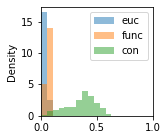

In [46]:
# TNC
plt.figure(figsize=(2,2))
for adj in ['euc','net','func','con']:
    if m[adj] != []:
        plt.hist(m[adj], bins = np.linspace(0,1,20), density=True, alpha=0.5, label=adj)
plt.legend()
plt.xlim([0,1])
plt.ylabel("Density")

Text(0, 0.5, 'Density')

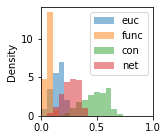

In [14]:
# Rail
plt.figure(figsize=(2,2))
for adj in ['euc','func','con','net']:
    plt.hist(m[adj], bins = np.linspace(0,1,20), density=True, alpha=0.5, label=adj)
plt.legend()
plt.xlim([0,1])
plt.ylabel("Density")

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


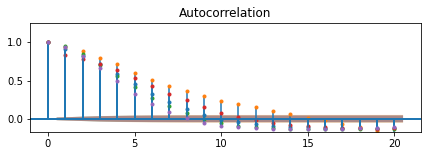

In [10]:
fig, ax = plt.subplots(figsize=(7,2))
for s in [0,30,60,90,120]:
    plot_acf(data['y'][0].squeeze()[:,s], ax=ax, lags=20, markersize=3,auto_ylims=True)

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/

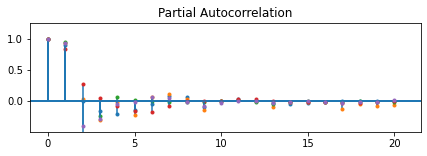

In [11]:
fig, ax = plt.subplots(figsize=(7,2))
for s in [0,30,60,90,120]:
    plot_pacf(data['y'][0].squeeze()[:,s], ax=ax, lags=20, markersize=3,auto_ylims=True)